In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict
import sys
import json

import yaml
import numpy as np
import pandas as pd
import cv2
import spacy
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax
from torch.utils.data import Dataset, DataLoader
import japanese_clip as ja_clip
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision.models import ResNet152_Weights
from umap import UMAP
import MeCab

sys.path.append('../')
from src.data.prepare import load_base_df
from src.models.MMBT.dataset import (BokeTextImageDataset, collate_fn)
from src.models.MMBT.mmbt import load_model
from src.models.utils import fix_seed, plot_confusion_matrix

MAX_SEQENCE_LEN = 48

## „Éá„Éº„ÇøË™≠„ÅøËæº„Åø

In [2]:
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

In [3]:
print(f'train_df.shape: {train_df.shape}')
display(train_df.head())

print(f'test_df.shape: {test_df.shape}')
display(test_df.head())

train_df.shape: (24962, 5)


id odai_photo_file_name  \
0  ge5kssftl       9fkys1gb2r.jpg   
1  r7sm6tvkj       c6ag0m1lak.jpg   
2  yp5aze0bh       whtn6gb9ww.jpg   
3  ujaixzo56       6yk5cwmrsy.jpg   
4  7vkeveptl       0i9gsa2jsm.jpg   

                                            text  is_laugh  \
0             Âêõ„Åó„Çá„Å£„Å°„ÇÖ„ÅÜ„ÇΩ„É¨Ëá™ÊÖ¢„Åô„Çã„Åë„Å©„ÄÅ„ÉÑ„É†„Ç∏ÔºíÂÄã„Å£„Å¶„Åù„Çì„Å™„Å´Â¨â„Åó„ÅÑ„ÅÆ„Åã„ÅÑÔºü         0   
1                            „Åì„Çå„Åß„Éê„É¨„Å™„ÅÑÔºüÊéàÊ•≠‰∏≠ÂØù„Å¶„ÇÇ„Éê„É¨„Å™„ÅÑÔºü         0   
2  „Äå„ÅÇ„Å™„Åü„ÇÇÊÑü„Åò„ÇãÔºü„Äç\n„Äé„ÅÇ„ÅÇ‚Ä¶„ÄÅÊÑü„Åò„Å¶„Çã‚Ä¶„Äè\n„ÄåÂæå„Çç„Å´ÂπΩÈúä„ÅÑ„Çã„Çà„Å≠‚Ä¶„Äç\n„ÄéÂ•≥„ÅÆ„Å™‚Ä¶„Äè         0   
3                 Â§ßÂ°öÊÑõËÅû„ÅÑ„Å¶„Åü„Çâ„ÅäËÖπÊ∏õ„Å£„Åü‚Ä¶„Åï„Åè„ÄÅ„Çâ„Çì„Åº„Å®Áâõ„Çø„É≥È£ü„Åπ„Åü„ÅÑ‚Ä¶          0   
4                                    ÁÜä„Å†„Å®ÊÄù„Å£„Åü„ÇâÂ´Å„Å†„Å£„Åü         0   

                               img_path  
0  ../dataset/imgs/train/9fkys1gb2r.jpg  
1  ../dataset/imgs/train/c6ag0m1lak.jpg  
2  ../dataset/imgs/train/whtn6gb9ww.jpg  
3  ../dataset/imgs/train/6yk5cwmrsy.jpg  
4  ../dataset/imgs/train/0i9gsa2jsm.jpg

test_df.shape: (6000, 5)


id odai_photo_file_name  \
0  rfdjcfsqq       nc1kez326b.jpg   
1  tsgqmfpef       49xt2fmjw0.jpg   
2  owjcthkz2       9dtscjmyfh.jpg   
3  rvgaocjyy       osa3n56tiv.jpg   
4  uxtwu5i69       yb1yqs4pvb.jpg   

                                                text  \
0                          ÂÉï„ÅÆ„Éû„Éû„ÄÅ„Ç≠„É£„É©ÂºÅ„ÅÆ„ÇÜ„Åß„Åü„Åæ„Åî„Å´ÔºòÊôÇÈñì„Åã„Åã„Å£„Åü„Çì„Å†   
1                                          „Åã„Çè„ÅÑ„ÅÑ„Åå‰Ωú„Çå„ÅüÔºÅ   
2                                           Êù•‰∏ñ„ÅÆÂøóËåÇÁî∞ÊôØÊ®π   
3                       „Å°„Çá„ÄÅ„ÅÇ„ÅÆ„ÄÅ„Ç™„Ç´„É≥„ÄÅ„Åì„ÇåÊ∞¥È¢®ÂëÇ„ÇÑ„Å≠„Çì„Åë„Å©„ÄÅ„Å™„Çì„ÅÆÂÜóË´á??   
4  „Äå‰ªäÊó•„ÅØÁöÜ„Åï„Çì„Å´„Ç∂„É™„Ç¨„Éã„Å®Ê∂àÈò≤Ëªä„ÅÆÈÅï„ÅÑ„ÇíÁü•„Å£„Å¶„ÇÇ„Çâ„ÅÑ„Åü„ÅÑ„Å®ÊÄù„ÅÑ„Åæ„Åô„Äç„Äé„Å©„Å£„Å°„ÇÇÂêå„Åò„Å†„Çç„ÄÇ‰∏°Êñπ...   

                              img_path  is_laugh  
0  ../dataset/imgs/test/nc1kez326b.jpg         0  
1  ../dataset/imgs/test/49xt2fmjw0.jpg         0  
2  ../dataset/imgs/test/9dtscjmyfh.jpg         0  
3  ../dataset/imgs/test/osa3n56tiv.jpg         0  
4  ../dataset/imgs/test/yb1yqs4pvb.jpg         0

## ÁâπÂæ¥ÈáèÊäΩÂá∫

### MMBT„ÅÆ‰∏≠ÈñìÂ±§„ÅÆÁâπÂæ¥ÈáèÊäΩÂá∫

‰ª•‰∏ã„ÅÆ„Éá„Ç£„É¨„ÇØ„Éà„É™ÊßãÊàê„Åß‰øùÂ≠ò„Åô„Çã„ÄÇ

```
./dataset
    |_EXPERIMENT_NAME (MMBT„Å™„Å©„ÅÆ„É¢„Éá„É´Â≠¶ÁøíÊôÇ„ÅÆÂÆüÈ®ìÂêç)
        |-1_fold (k-fold„Åù„Çå„Åû„Çå„Å´„Åä„ÅÑ„Å¶‰ΩúÊàê„Åï„Çå„Åü„É¢„Éá„É´)
        |  |- train.csv (1 foldÁõÆ„ÅÆÂ≠¶Áøí„Å´‰ΩøÁî®„Åï„Çå„Åü„Éá„Éº„Çø„ÅÆ„Éô„ÇØ„Éà„É´„ÄÇ „Åì„Å°„Çâ„Åß„Éë„É©„É°„Éº„Çø„ÉÅ„É•„Éº„Éã„É≥„Ç∞, ÊúÄÁµÇÁöÑ„Å™„É¢„Éá„É´‰ΩúÊàê„ÇíÂÆüÊñΩ)
        |  |- valid.csv (1 foldÁõÆ„ÅÆÊ§úË®º„Å´‰ΩøÁî®„Åï„Çå„Åü„Éá„Éº„Çø„ÅÆ„Éô„ÇØ„Éà„É´„ÄÇ train.csv„ÅßÊúÄÁµÇÁöÑ„Å™„É¢„Éá„É´„Çí‰ΩúÊàê„Åó„ÄÅ„Åì„Å°„Çâ„ÅßË©ï‰æ°)
        |  |_ test.csv (ÁµêÊûúÂá∫ÂäõÁî®)
        |
        :
        |_k_fold„ÄÄ(1_fold„Å®Âêå„ÅòÊßãÊàê)
```

Â≠¶Áøí„ÅÆÊµÅ„Çå„Å®„Åó„Å¶„ÅØ„ÄÅ‰∏ãË®ò„ÇíÊÉ≥ÂÆö

fold„Åî„Å®„Å´‰ª•‰∏ã„ÇíÂÆüÊñΩ

1. csv„Å´‰ªñ„ÅÆÁâπÂæ¥Èáè„Çí‰ªò‰∏é„ÄÇ ex. textÈï∑, ÊñáÁ´†‰∏≠„ÅÆ‰∫∫Áâ©Âêç„ÅÆÊï∞, ÁîªÂÉè‰∏≠„ÅÆÁä¨„Å®Áå´„ÅÆÊï∞, ‰∫∫„ÅÆÊï∞ „Å™„Å©„ÄÇ

2. „Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„Çø„ÉÅ„É•„Éº„Éã„É≥„Ç∞(train.csv„Åßcross validation„Åó„Å¶Ê±∫„ÇÅ„Çã)

3. „É¢„Éá„É´ÊúÄÁµÇÂåñ(„ÉÅ„É•„Éº„Éã„É≥„Ç∞„Åó„Åü„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„Çø„Åßtrain.csv„ÅÆ„Éá„Éº„Çø„ÅßÂ≠¶Áøí„Åó„ÄÅvalid.csv„Åßloss„Å™„Å©„ÅÆË©ï‰æ°ÊåáÊ®ôÂèñÂæó„ÄÇ)

4. test.csv„Çí‰∫àÊ∏¨

„Åù„ÅÆÂæå„ÄÅ„É¢„Éá„É´„Åî„Å®„ÅÆtest.csv„ÅÆ‰∫àÊ∏¨ÁµêÊûú„ÅÆÂπ≥Âùá„ÇíÊèêÂá∫


In [3]:
def vectorize_ds(model, dataloader, device):
    model = model.to(device)
    vector = []
    for ds in tqdm(dataloader):
        ds = {k: v.to(device) for k, v in ds.items()}
        with torch.no_grad():
            # ÊúÄÁµÇÈö†„ÇåÂ±§„ÅÆÂßã„Åæ„Çä„ÅÆÊñáÂ≠ó„ÅÆ„Éô„ÇØ„Éà„É´„ÇíÂèñÂæó„Åó„Å¶„ÄÅÁâπÂæ¥Èáè„Å®„Åó„Å¶Áî®„ÅÑ„Çã„ÄÇ
            hidden_states = model(**ds).hidden_states[-1][:, 0]
            # numpy array„Å´„Åô„Çã„ÄÇ
            hidden_states = hidden_states.cpu().detach().numpy() if torch.cuda.is_available() else hidden_states.cpu().numpy()
            vector.append(hidden_states)
    return np.concatenate(vector)


def load_validate_model(src):
    model = load_model(output_hidden_states=True)
    model.load_state_dict(torch.load(src))
    return model

In [5]:
# ÂÆöÊï∞ÂÆöÁæ©
EXPERIMENT_NAME = '5fold_stratified_mmbt_seed_0'
VECTOR_COL_PREFIX = 'mmbt_vector'
ID_COL = 'id'

# cpu or gpu„ÇíÂèñÂæó
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# tokenizerÂèñÂæó
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# ‰øùÂ≠òÊ∏à„Åø„ÅÆ„É¢„Éá„É´„Éë„Çπ‰∏ÄË¶ßÂèñÂæó
MODEL_SRC_BASE = Path(f'../model/{EXPERIMENT_NAME}/')
MODEL_SRC_LIST = [
    MODEL_SRC_BASE / 'fold_1/checkpoint-225/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_2/checkpoint-175/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_3/checkpoint-250/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_4/checkpoint-250/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_5/checkpoint-175/pytorch_model.bin'
]
# ÂØæÂøú„Åô„ÇãÊ§úË®º„Éá„Éº„Çø„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Çí‰øùÂ≠ò„Åó„Åü„É≠„Ç∞„Åå„ÅÇ„Çã„Éá„Ç£„É¨„ÇØ„Éà„É™„ÇíÂÆöÁæ©
LOG_DIR = Path('../results/5fold_stratified_mmbt_seed_0/')
# ‰øùÂ≠òÂÖàÂÆöÁæ©
DST_ROOT = Path(f'../dataset/processed/{EXPERIMENT_NAME}')
# test„Éá„Éº„Çø„É≠„Éº„ÉÄ„ÉºÂÆöÁæ©
test_ds = BokeTextImageDataset(test_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
test_dl = DataLoader(test_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)

for i, model_src in enumerate(MODEL_SRC_LIST):
    assert model_src.exists(), 'Ë™≠„ÅøËæº„ÅøÂØæË±°„ÅÆ„É¢„Éá„É´„Éë„Çπ„Åå„ÅÇ„Çã„Åì„Å®'
    relpath = os.path.relpath(model_src, MODEL_SRC_BASE)
    fold_name = relpath.split(os.sep)[0]
    log_file_path = LOG_DIR / f'{fold_name}_log.json'
    assert log_file_path.exists(), 'Ê§úË®º„Éá„Éº„Çø„Ç§„É≥„Éá„ÉÉ„ÇØ„ÇπÂèñÂæóÁî®„ÅÆjson„ÅåÂ≠òÂú®„Åô„Çã„Åì„Å®'
    with open(log_file_path, 'r') as f:
        data = json.load(f)
        train_idx = data['train_idx']
        valid_idx = data['valid_idx']
    # „Éô„ÇØ„Éà„É´Âåñ
    target_ds = BokeTextImageDataset(train_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
    target_dl = DataLoader(target_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)
    model = load_validate_model(model_src)
    model.to(device)
    model.eval()
    train_hidden_vector = vectorize_ds(model, target_dl, device)
    test_hidden_vector = vectorize_ds(model, test_dl, device)
    # csv„Å´‰øùÂ≠ò
    dst_dir = DST_ROOT / fold_name
    if not dst_dir.exists():
        dst_dir.mkdir(parents=True)
    train_vector_df = pd.DataFrame(train_hidden_vector[train_idx]).add_prefix(VECTOR_COL_PREFIX)
    train_vector_df[ID_COL] = train_df.iloc[train_idx][ID_COL].to_list()
    train_vector_df.to_csv(str(dst_dir / 'train.csv'), index=False)
    valid_vector_df = pd.DataFrame(train_hidden_vector[valid_idx]).add_prefix(VECTOR_COL_PREFIX)
    valid_vector_df[ID_COL] = train_df.iloc[valid_idx][ID_COL].to_list()
    valid_vector_df.to_csv(str(dst_dir / 'valid.csv'), index=False)
    test_vector_df = pd.DataFrame(test_hidden_vector).add_prefix(VECTOR_COL_PREFIX)
    test_vector_df[ID_COL] = test_df[ID_COL]
    test_vector_df.to_csv(str(dst_dir / 'test.csv'), index=False)
    
    print(f'{i + 1} / {len(MODEL_SRC_LIST)} finisied')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

1 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

2 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

3 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

4 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

5 / 5 finisied


#### ÊäΩÂá∫„Åó„Åü‰∏≠ÈñìÂ±§ÁâπÂæ¥Èáè„Çíumap„ÅßÂèØË¶ñÂåñ

UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Sat Oct  8 12:31:59 2022 Construct fuzzy simplicial set
Sat Oct  8 12:31:59 2022 Finding Nearest Neighbors
Sat Oct  8 12:31:59 2022 Building RP forest with 9 trees
Sat Oct  8 12:31:59 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Sat Oct  8 12:31:59 2022 Finished Nearest Neighbor Search
Sat Oct  8 12:31:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct  8 12:32:09 2022 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Sat Oct  8 12:32:09 2022 Construct fuzzy simplicial set
Sat Oct  8 12:32:09 2022 Finding Nearest Neighbors
Sat Oct  8 12:32:09 2022 Building RP forest with 9 trees
Sat Oct  8 12:32:10 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Sat Oct  8 12:32:10 2022 Finished Nearest Neighbor Search
Sat Oct  8 12:32:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct  8 12:32:19 2022 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Sat Oct  8 12:32:20 2022 Construct fuzzy simplicial set
Sat Oct  8 12:32:20 2022 Finding Nearest Neighbors
Sat Oct  8 12:32:20 2022 Building RP forest with 9 trees
Sat Oct  8 12:32:20 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Sat Oct  8 12:32:20 2022 Finished Nearest Neighbor Search
Sat Oct  8 12:32:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct  8 12:32:30 2022 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Sat Oct  8 12:32:30 2022 Construct fuzzy simplicial set
Sat Oct  8 12:32:30 2022 Finding Nearest Neighbors
Sat Oct  8 12:32:30 2022 Building RP forest with 9 trees
Sat Oct  8 12:32:31 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Sat Oct  8 12:32:31 2022 Finished Nearest Neighbor Search
Sat Oct  8 12:32:31 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct  8 12:32:40 2022 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Sat Oct  8 12:32:41 2022 Construct fuzzy simplicial set
Sat Oct  8 12:32:41 2022 Finding Nearest Neighbors
Sat Oct  8 12:32:41 2022 Building RP forest with 9 trees
Sat Oct  8 12:32:41 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Sat Oct  8 12:32:41 2022 Finished Nearest Neighbor Search
Sat Oct  8 12:32:41 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct  8 12:32:51 2022 Finished embedding


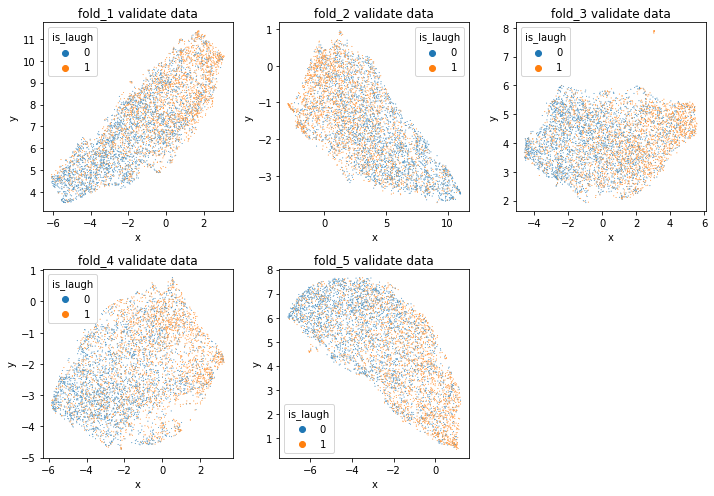

In [7]:
ROOT = '../dataset/processed/5fold_stratified_mmbt_seed_0'
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 7))
for i, fold_name in enumerate(sorted(os.listdir(ROOT), key=lambda x: x.split('_')[-1])):
    row, col = i // 3, i % 3
    plot_df = pd.read_csv(str(Path(ROOT) / fold_name / 'valid.csv'))
    id_laugh_merged_df = plot_df.merge(train_df[['id', 'is_laugh']], on='id')
    X_scaled = MinMaxScaler().fit_transform(plot_df.drop(columns=['id']))
    mapper = UMAP(n_components=2, metric='cosine', random_state=0, verbose=1).fit(X_scaled)
    df_emb = pd.DataFrame(mapper.embedding_, columns=['x', 'y'])
    df_emb['is_laugh'] = id_laugh_merged_df['is_laugh']
    ax = axes[row, col]
    sns.scatterplot(data=df_emb, x='x', y='y', hue='is_laugh', ax=ax, s=1)
    ax.set_title(f'{fold_name} validate data')
axes[-1, -1].axis('off')
fig.tight_layout()

## „ÉÜ„Ç≠„Çπ„ÉàÈï∑„ÅÆÁâπÂæ¥ÈáèËøΩÂä†

In [54]:
TEXT_LEN_COL = 'text_len'
train_txt_len_df = pd.DataFrame({
    TEXT_LEN_COL: train_df['text'].str.len(),
    'id': train_df['id']
})
test_txt_len_df = pd.DataFrame({
    TEXT_LEN_COL: test_df['text'].str.len(),
    'id': test_df['id']
})
train_txt_len_df.to_csv('../dataset/processed/train_text_len.csv', index=False)
test_txt_len_df.to_csv('../dataset/processed/test_text_len.csv', index=False)

## CLIP„Å´„Çà„ÇãÁîªÂÉè„Å®„ÉÜ„Ç≠„Çπ„ÉàÈñì„ÅÆÈ°û‰ººÂ∫¶ÁâπÂæ¥ÈáèËøΩÂä†

ÂàÜÂ∏É„Åã„Çâ„ÄÅ„ÅÇ„Åæ„ÇäÊúâÂäπ„Å™ÁâπÂæ¥Èáè„Å®„ÅØ„Å™„Çâ„Å™„ÅÑ„Åã„Å®ÊÄù„Çè„Çå„Çã

In [36]:
class CLIPDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, image_preprocess, device, max_seq_len=MAX_SEQENCE_LEN):
        self.df = df
        self.tokenizer = tokenizer
        self.image_preprocess = image_preprocess
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        encodings = ja_clip.tokenize(
            texts=[row['text']],
            max_seq_len=self.max_seq_len,
            tokenizer=self.tokenizer,
            device=device
        )
        image = Image.open(row['img_path'])
        image = self.image_preprocess(image).to(device)
        return encodings, image

def collate_fn(batch):
    encodings = defaultdict(list)
    images = []
    for element in batch:
        for key, val in element[0].items():
            encodings[key].append(val)
        images.append(element[1])
    encodings = {key: torch.concat(val) for key, val in encodings.items()}
    images = torch.stack(images)
    return encodings, images


def similarity_arr_with_clip(model, dl: DataLoader):
    result = []
    for ds in tqdm(dl):
        image_features = model.get_image_features(ds[1])
        text_features = model.get_text_features(**ds[0])
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # ‰ªñ„ÅÆÁîªÂÉè„ÅÆË™¨ÊòéÊñá„Å®„ÅÆÈ°û‰ººÂ∫¶„ÅØ‰∏çË¶Å„Å™„ÅÆ„ÅßÂØæËßíÊàêÂàÜ„ÅÆ„ÅøÂèñÂæó
        similarity_arr = torch.diag(image_features @ text_features.T)
        similarity_arr = similarity_arr.cpu().detach().numpy() if torch.cuda.is_available() else similarity_arr.cpu().numpy()
        result.append(similarity_arr)
    return np.concatenate(result)

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = ja_clip.load("rinna/japanese-clip-vit-b-16", cache_dir="/tmp/japanese_clip", device=device)
model.eval()
tokenizer = ja_clip.load_tokenizer()

In [56]:
train_clip_ds = CLIPDataset(train_df, tokenizer, preprocess, device)
train_clip_dl = DataLoader(train_clip_ds, batch_size=12, collate_fn=collate_fn)
train_similarity_arr = similarity_arr_with_clip(model, train_clip_dl)

train_similarity_df = pd.DataFrame({
    'similarity': train_similarity_arr,
    'id': train_df['id']
})
train_similarity_df.to_csv('../dataset/processed/train_similarity.csv', index=False)

  0%|          | 0/2081 [00:00<?, ?it/s]

In [57]:
train_similarity_df['is_laugh'] = train_df['is_laugh']

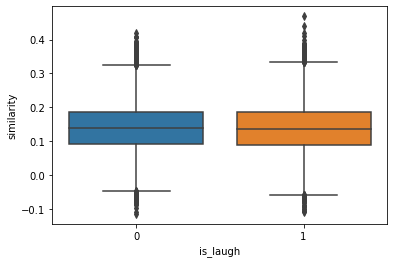

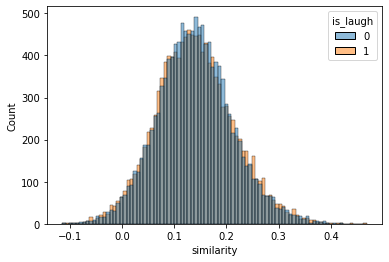

In [58]:
sns.boxplot(data=train_similarity_df, x='is_laugh', y='similarity')
plt.show()
sns.histplot(data=train_similarity_df, x='similarity', hue='is_laugh')
plt.show()

In [59]:
test_clip_ds = CLIPDataset(test_df, tokenizer, preprocess, device)
test_clip_dl = DataLoader(test_clip_ds, batch_size=12, collate_fn=collate_fn)
test_similarity_arr = similarity_arr_with_clip(model, test_clip_dl)

test_similarity_df = pd.DataFrame({
    'similarity': test_similarity_arr,
    'id': test_df['id']
})
test_similarity_df.to_csv('../dataset/processed/test_similarity.csv', index=False)

  0%|          | 0/500 [00:00<?, ?it/s]

## TF-IDFÁâπÂæ¥Èáè

ÂêÑÊñáÁ´†„ÅÆTF-IDF„Éô„ÇØ„Éà„É´„ÅÆÊúÄÂ§ßÂÄ§„ÄÅÂπ≥Âùá„ÇíÁâπÂæ¥Èáè„Åô„Çã„ÄÇ

In [3]:
class MecabTokenizer:
    def __init__(self, wakati):
        self.wakati = wakati

    def __call__(self, text):
        return self.wakati.parse(text).split()


def extract_tfidf_static_info(tfidf_vector):
    result = {
        'tfidf_mean': [],
        'tfidf_max': [],
        'tfidf_std': [],
        'tfidf_min': []
    }
    for v in tqdm(tfidf_vector, total=tfidf_vector.shape[0]):
        result['tfidf_mean'].append(v.toarray().mean())
        result['tfidf_max'].append(v.toarray().max())
        result['tfidf_std'].append(v.toarray().std())
        result['tfidf_min'].append(v.toarray().min())
    return result

In [5]:
mecab_tokenizer = MecabTokenizer(MeCab.Tagger('-Owakati'))
tfidf = TfidfVectorizer(tokenizer=mecab_tokenizer)
train_txts = train_df['text'].values
train_vector = tfidf.fit_transform(train_txts)

In [6]:
test_txts = test_df['text'].values
test_vector = tfidf.transform(test_txts)

  0%|          | 0/24962 [00:00<?, ?it/s]

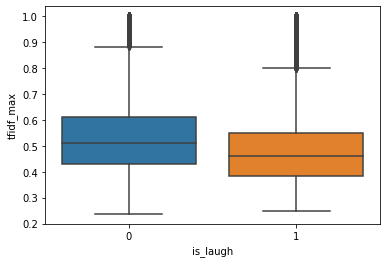

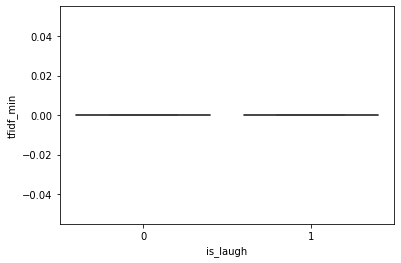

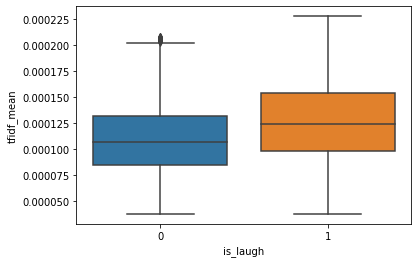

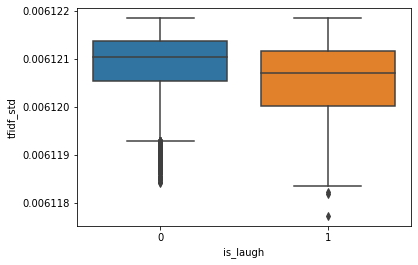

In [7]:
# Â≠¶Áøí„Éá„Éº„Çø„ÅßÂàÜÂ∏É„ÇíÁ¢∫Ë™ç
train_tfidf_df = pd.DataFrame(extract_tfidf_static_info(train_vector))
plot_df = train_tfidf_df.copy()
plot_df['is_laugh'] = train_df['is_laugh']
y_cols = ['tfidf_max', 'tfidf_min', 'tfidf_mean', 'tfidf_std']
for y_col in y_cols:
    sns.boxplot(data=plot_df, x='is_laugh', y=y_col)
    plt.show()

In [8]:
train_tfidf_df = pd.DataFrame(extract_tfidf_static_info(train_vector))
train_tfidf_df['id'] = train_df['id']
train_tfidf_df = train_tfidf_df.drop(columns=['tfidf_min'])
train_tfidf_df.to_csv('../dataset/processed/train_tfidf_vector.csv', index=False)

test_vector_df = pd.DataFrame(extract_tfidf_static_info(test_vector))
test_vector_df['id'] = test_df['id']
test_vector_df = test_vector_df.drop(columns=['tfidf_min'])
test_vector_df.to_csv('../dataset/processed/test_tfidf_vector.csv', index=False)

  0%|          | 0/24962 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

## Âõ∫ÊúâË°®ÁèæÊäΩÂá∫

In [27]:
class ExtractPersonApearInTxt:
    def __init__(self, nlp=None):
        self.nlp = nlp if nlp is not None else spacy.load('ja_ginza_electra')

    def __call__(self, texts):
        docs = self.nlp.pipe(texts)
        n_texts = len(texts)
        results = [0] * n_texts
        for i, doc in enumerate(tqdm(docs, total=n_texts)):
            for ent in doc.ents:
                if ent.label_ == 'Person':
                    results[i] = 1
        return results

In [28]:
nlp = spacy.load('ja_ginza_electra')

In [29]:
extract_person_apear = ExtractPersonApearInTxt()
train_has_person_list = extract_person_apear(train_df['text'].values.tolist())
test_has_person_list = extract_person_apear(test_df['text'].values.tolist())

  0%|          | 0/24962 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

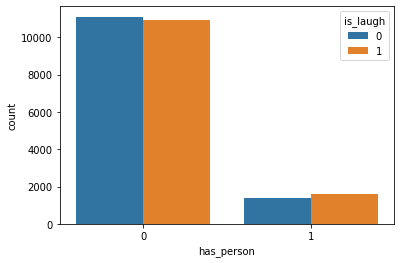

In [30]:
plot_df = pd.DataFrame({'has_person': train_has_person_list, 'is_laugh': train_df['is_laugh'].to_list()})
sns.countplot(data=plot_df, x='has_person', hue='is_laugh')
plt.show()

In [32]:
np.unique(train_has_person_list, return_counts=True)

(array([0, 1]), array([21993,  2969]))

In [31]:
np.unique(test_has_person_list, return_counts=True)

(array([0, 1]), array([5270,  730]))

In [33]:
train_has_person_df = pd.DataFrame({'id': train_df['id'], 'has_person': train_has_person_list})
train_has_person_df.to_csv('../dataset/processed/train_has_person.csv', index=False)
test_has_person_df = pd.DataFrame({'id': test_df['id'], 'has_person': test_has_person_list})
test_has_person_df.to_csv('../dataset/processed/test_has_person.csv', index=False)

## Áâ©‰ΩìÊ§úÁü•„ÅßÂÜô„Å£„Å¶„ÅÑ„ÇãÁâ©‰ΩìÊï∞„ÇíÁâπÂæ¥Èáè„Å´„Åô„Çã

- „Éá„Éº„Çø„Çª„ÉÉ„Éà: coco https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco.yaml

- model: yolov5 https://docs.ultralytics.com/tutorials/pytorch-hub/

In [6]:
class ExtractNumObjectInImage:
    def __init__(self, model=None, coco_yml_path: str='../third_party/coco.yaml', prefix='_counts'):
        self.model = model if model is not None else torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        self.model.eval()
        self.idx2label = self._load_yml(coco_yml_path)
        self.prefix = '_counts'

    @staticmethod
    def _load_yml(yml_path: str):
        with open(yml_path, 'r') as f:
            coco = yaml.safe_load(f)
        return coco['names']

    def _label_count_dict_for_one_image(self, result):
        labels, counts = np.unique(result, return_counts=True)
        results = {f'{label}{self.prefix}': 0 for label in self.idx2label.values()}
        for idx, count in zip(labels, counts):
            label = f'{self.idx2label[idx]}{self.prefix}'
            results[label] = count
        return results

    def __call__(self, dl: DataLoader) -> pd.DataFrame:
        result_df_base = []
        for ds in tqdm(dl, total=len(dl)):
            preds = self.model(ds)
            for pred in preds.xyxy:
                labels_in_img = pred.cpu().detach().numpy() if torch.cuda.is_available() else preds.cpu().numpy()
                label_dict = self._label_count_dict_for_one_image(labels_in_img[:, -1])
                result_df_base.append(label_dict)
        return pd.DataFrame(result_df_base)


class ObjectDetectionDataSet(Dataset):
    def __init__(self, img_path_list):
        self.img_path_list = img_path_list
    
    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, index):
        return self.img_path_list[index]

In [7]:
BATCH_SIZE = 32
# Â≠¶ÁøíÁî®„Éá„Éº„Çø„ÅÆcsvÂåñ
extract_num_object_in_img = ExtractNumObjectInImage()
train_od_dl = DataLoader(ObjectDetectionDataSet(train_df['img_path'].to_list()), batch_size=BATCH_SIZE)
train_od_df = extract_num_object_in_img(train_od_dl)
train_od_df['id'] = train_df['id']
train_od_df.to_csv('../dataset/processed/train_od_counts.csv', index=False)

# „ÉÜ„Çπ„ÉàÁî®„Éá„Éº„Çø„ÅÆcsvÂåñ
test_od_dl = DataLoader(ObjectDetectionDataSet(test_df['img_path'].to_list()), batch_size=BATCH_SIZE)
test_od_df = extract_num_object_in_img(test_od_dl)
test_od_df['id'] = test_df['id']
test_od_df.to_csv('../dataset/processed/test_od_counts.csv', index=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: YOLOv5 requirement "tqdm>=4.64.0" not found, attempting AutoUpdate...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ‚ö†Ô∏è Restart runtime or rerun command for updates to take effect

YOLOv5 üöÄ 2022-9-29 Python-3.7.13 torch-1.12.0 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7974MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

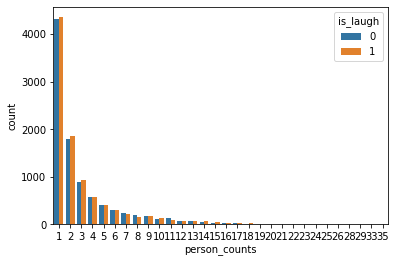

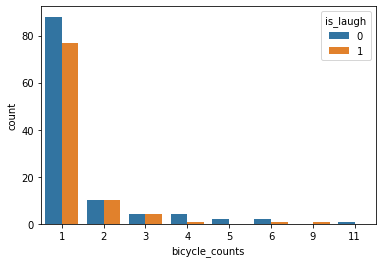

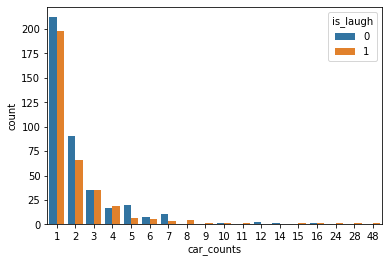

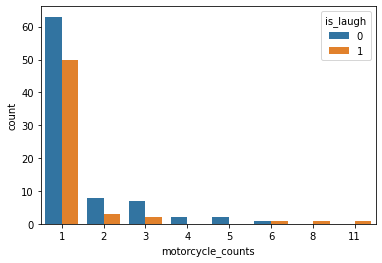

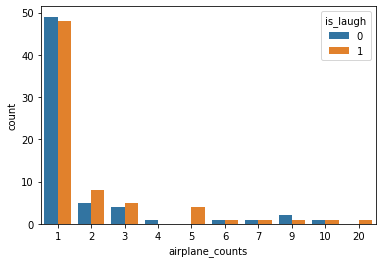

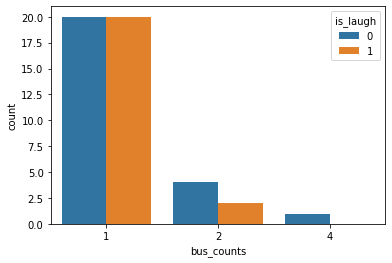

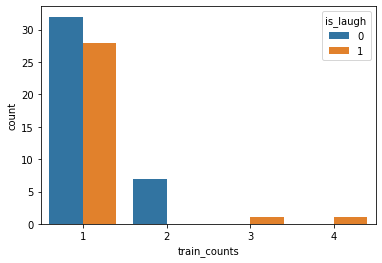

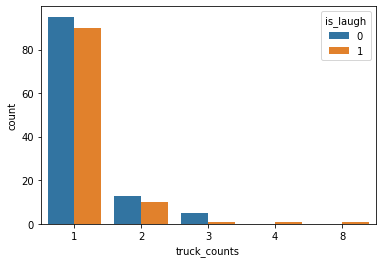

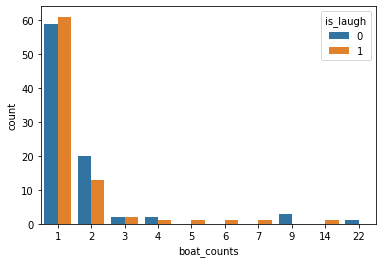

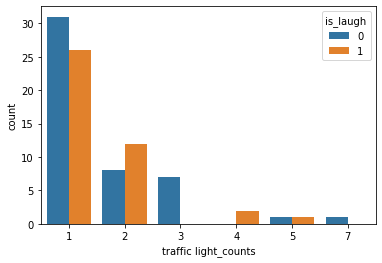

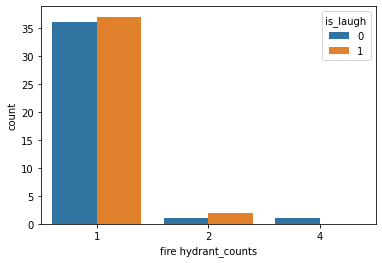

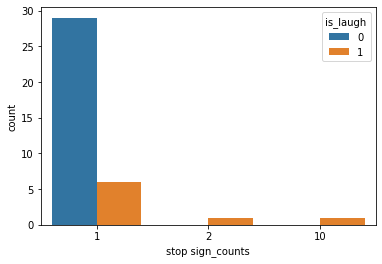

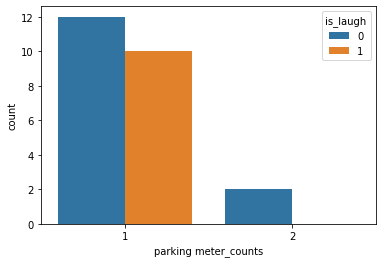

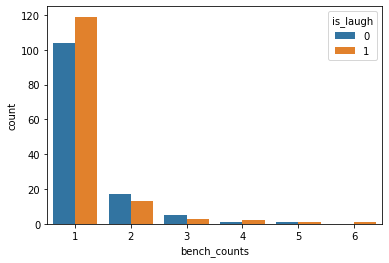

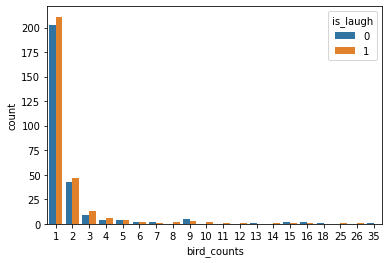

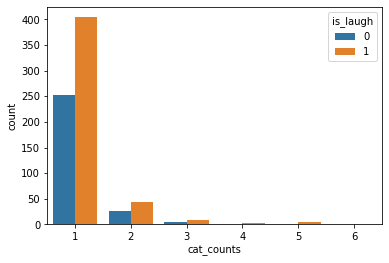

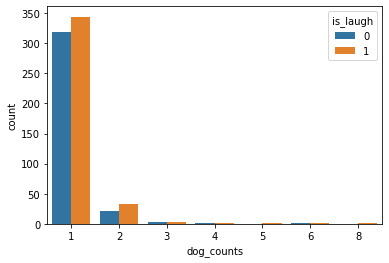

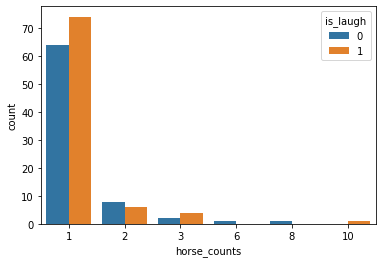

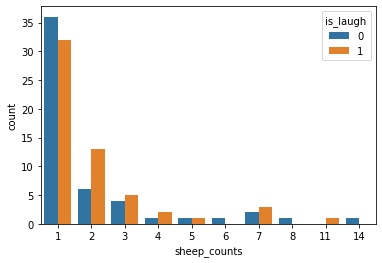

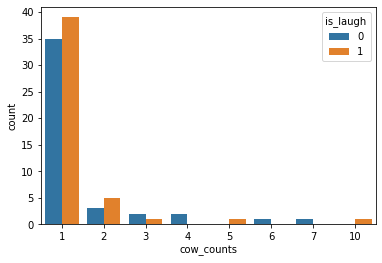

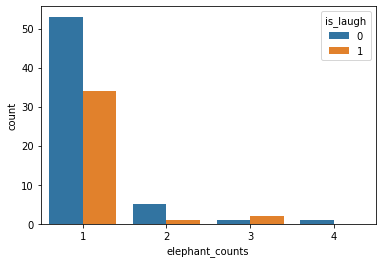

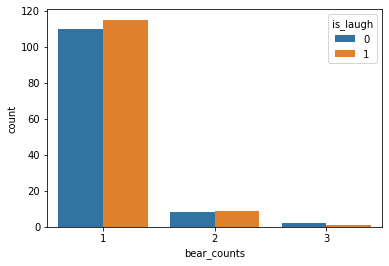

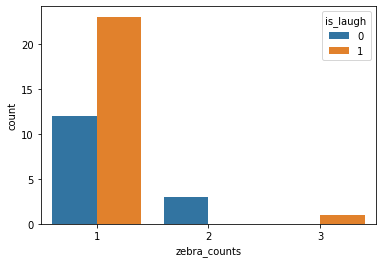

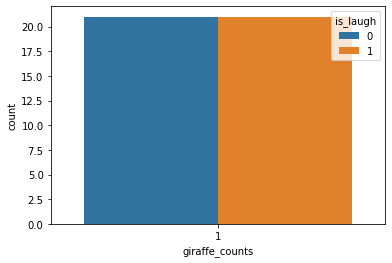

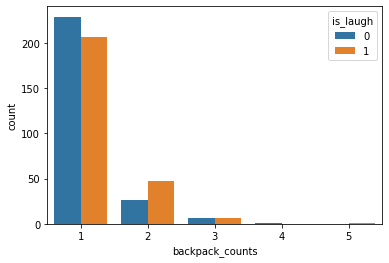

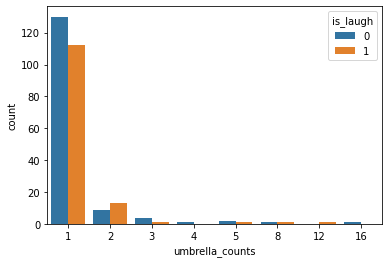

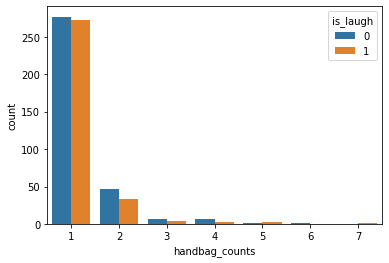

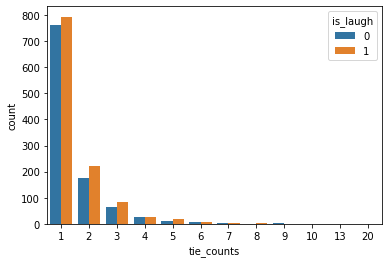

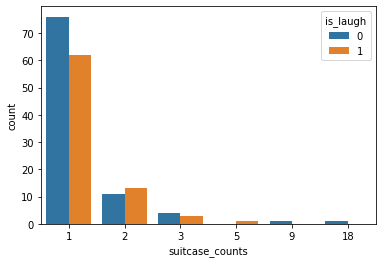

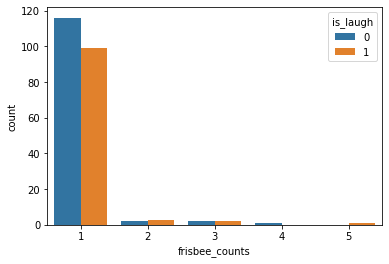

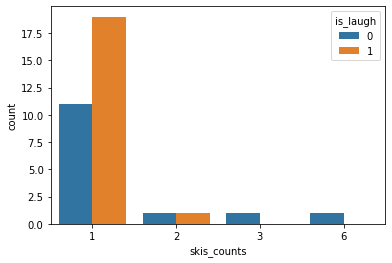

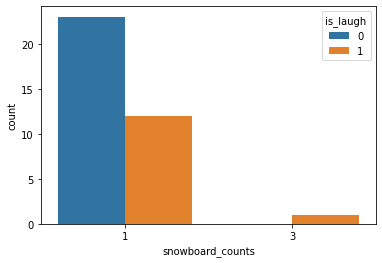

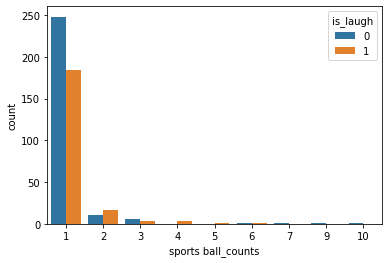

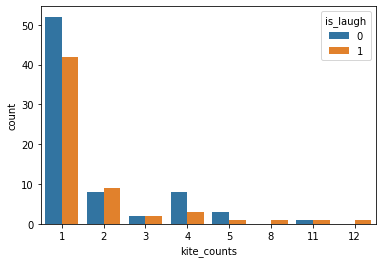

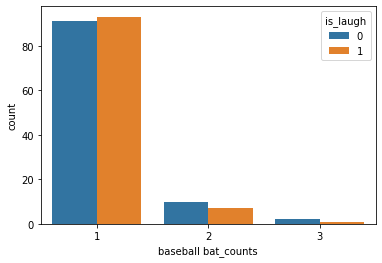

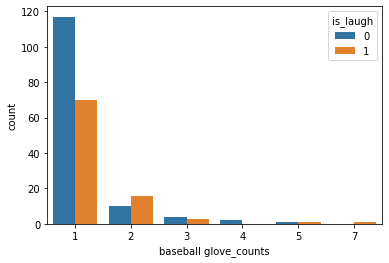

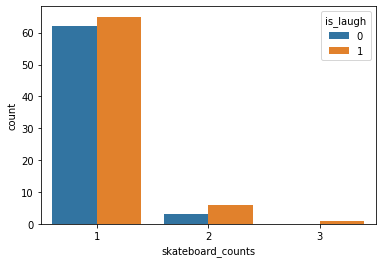

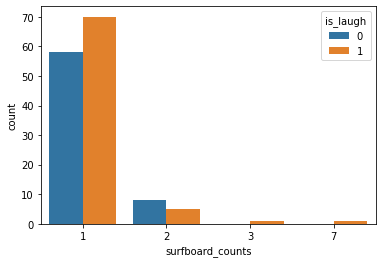

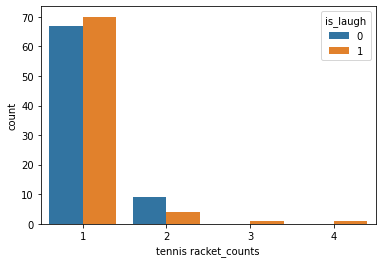

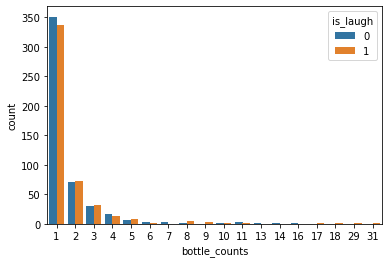

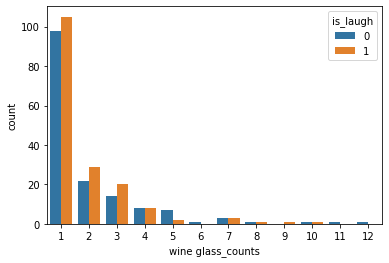

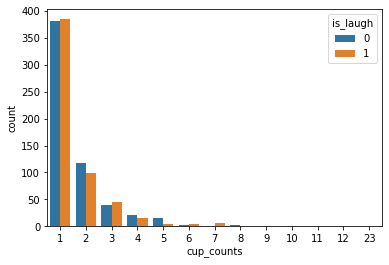

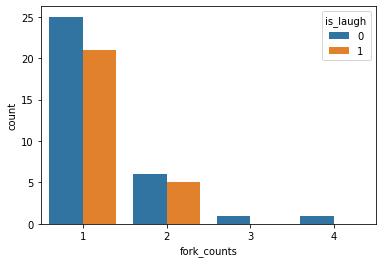

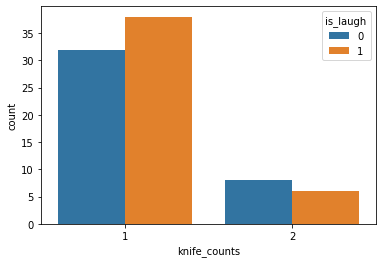

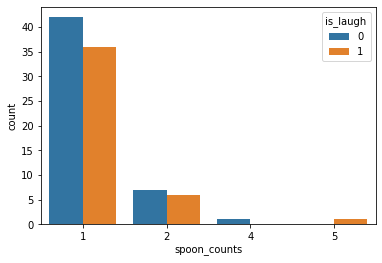

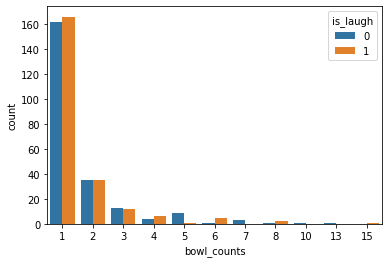

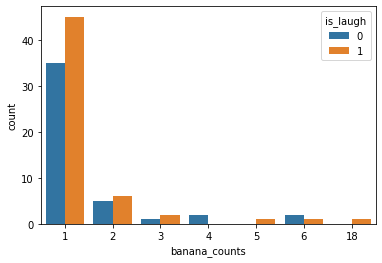

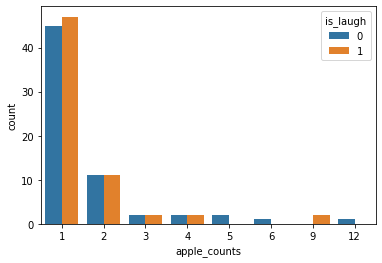

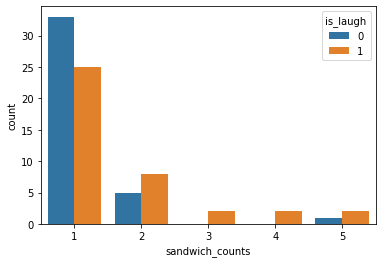

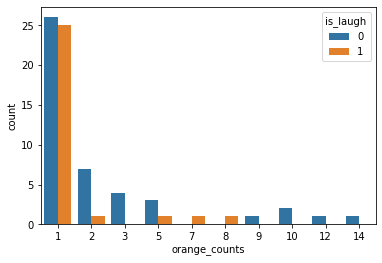

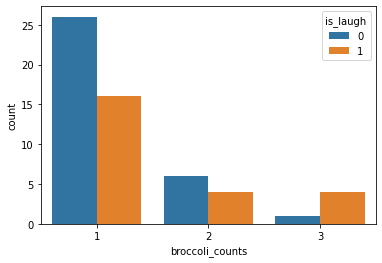

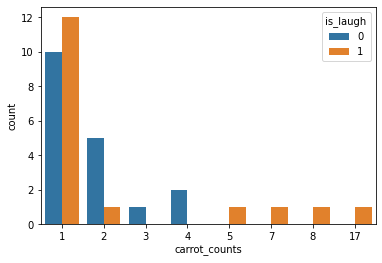

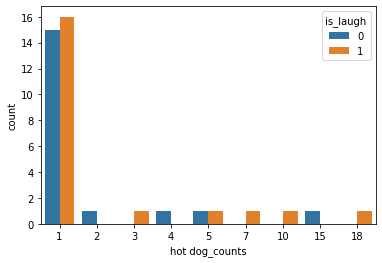

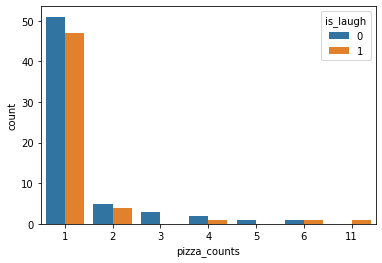

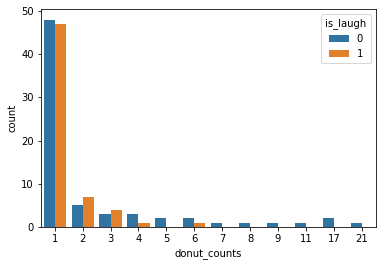

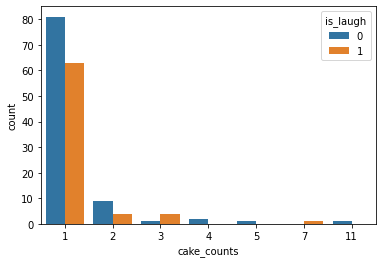

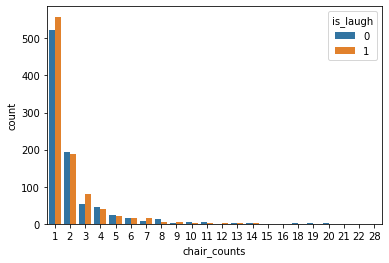

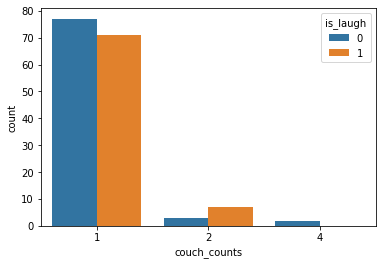

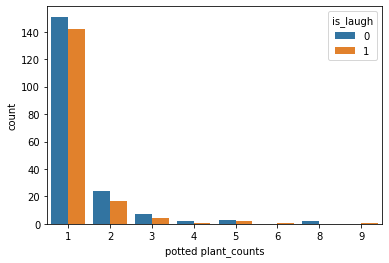

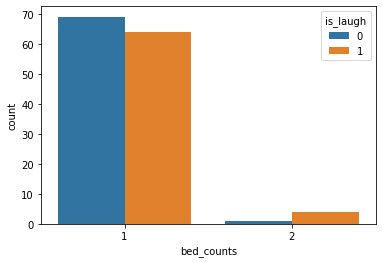

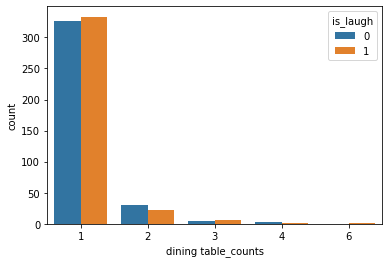

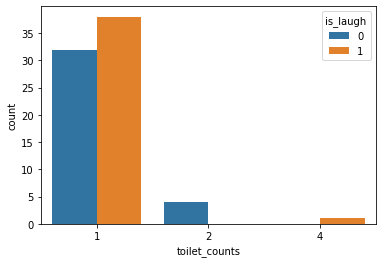

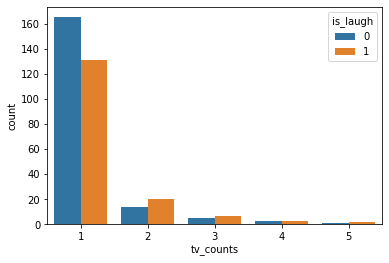

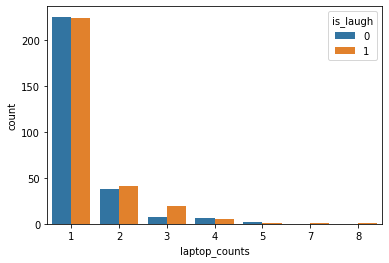

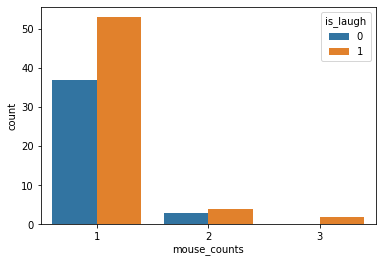

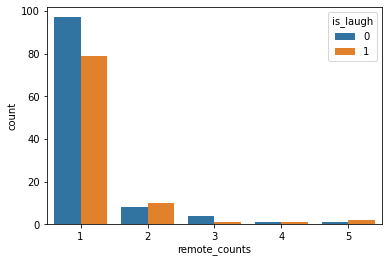

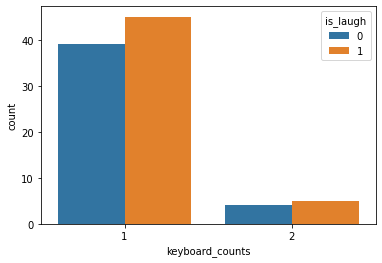

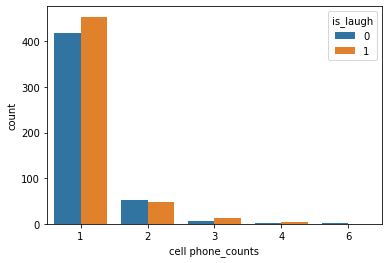

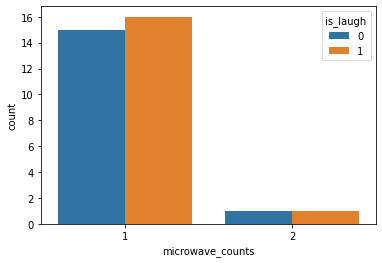

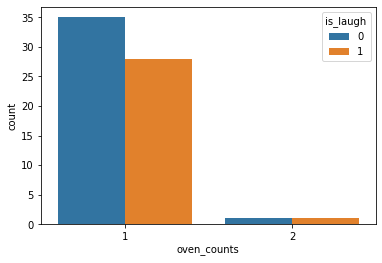

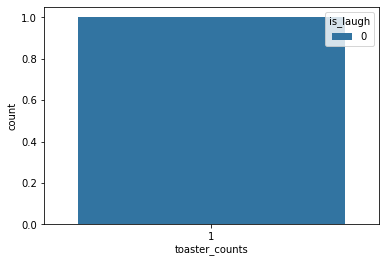

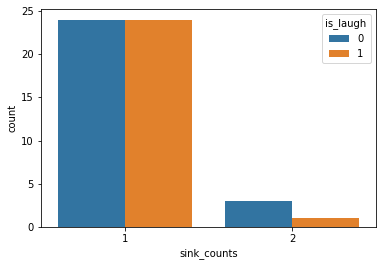

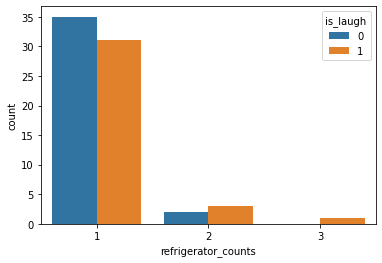

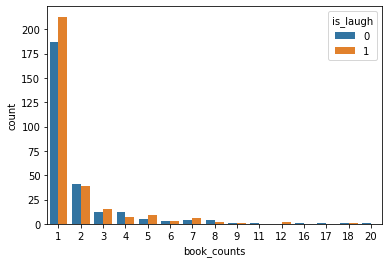

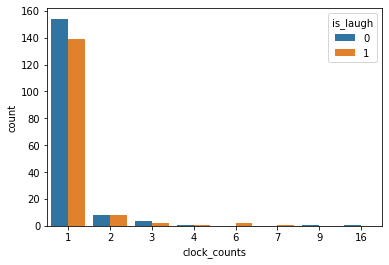

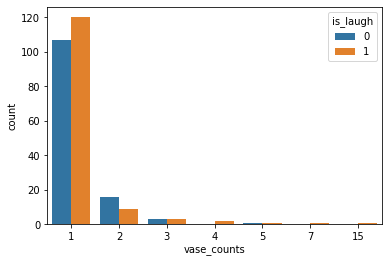

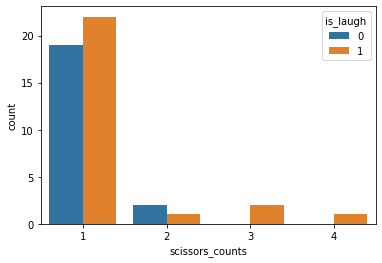

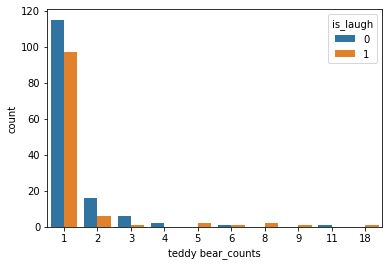

ValueError: min() arg is an empty sequence

In [4]:
train_od_df = pd.read_csv('../dataset/processed/train_od_counts.csv')
plot_df = train_od_df.copy()
plot_df['is_laugh'] = train_df['is_laugh']
hur = 'is_laugh'
x_col_list = plot_df.drop(columns=['is_laugh', 'id']).columns.to_list()
for x in x_col_list:
    target_df = plot_df[plot_df[x] != 0]
    sns.countplot(data=target_df, x=x, hue='is_laugh')
    plt.show()